**Project Overview**

The goal of this project is to collect motion data, extract meaningful features, and use a Hidden Markov Model (HMM) to infer human activity states such as standing, walking, jumping, and still.

Sensors Recorded:
- **Accelerometer:** x, y, z axes
- **Gyroscope:** x, y, z axes

Activities Performed:
| Activity | Duration | Notes |
|-----------|-----------|--------|
| Standing | 5–10 s | Keep the phone steady at waist level |
| Walking | 5–10 s | Maintain a consistent pace |
| Jumping | 5–10 s | Perform 3–5 continuous jumps |
| Still | 5–10 s | Place the phone on a flat surface |

Each recording was taken at a sampling rate of **70 Hz**, and the collected data was saved as `.csv` files with timestamps.


**Feature Extraction Summary**

From the raw accelerometer and gyroscope readings, features were extracted in both **time** and **frequency** domains to capture movement patterns.

Examples of extracted features:
- **Time-domain features:** mean, variance, standard deviation, signal magnitude area (SMA), correlations between axes.
- **Frequency-domain features:** dominant frequency, spectral energy, FFT components.

The extracted features were saved in a file called `features.csv`, which contains all four activities combined with their corresponding labels.


Load Extracted Data

In [2]:
from hmmlearn import hmm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix


In [3]:
import pandas as pd

# Load preprocessed features
df = pd.read_csv("features.csv")

# Standardize column name to 'label'
df.rename(columns={'activity': 'label', 'Activity': 'label', 'Label': 'label'}, inplace=True)

# Display basic information
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (948, 94)


,accel_x_mean,accel_x_std,accel_x_var,accel_x_mad,accel_y_mean,accel_y_std,accel_y_var,accel_y_mad,accel_z_mean,accel_z_std,...,acc_res_dom_freq,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,label,start_time
0,-0.325147,1.005483,1.010997,0.715388,-0.125287,1.950710,3.805271,1.288558,-0.052421,7.376959,...,0.781250,50.754583,248.492811,0.781250,224.096697,0.390625,147.161871,3.906250,jumping,1.761134e+09
1,-0.333427,1.212630,1.470472,0.896227,-0.036922,2.340061,5.475887,1.697479,0.170994,8.711320,...,3.906250,65.812950,183.212361,3.906250,164.318067,1.953125,137.923398,0.781250,jumping,1.761134e+09
2,-0.150583,1.298404,1.685853,0.915027,-0.092910,1.918203,3.679501,1.403808,-0.045061,8.365517,...,3.906250,64.546681,193.348538,3.906250,176.854559,1.953125,164.362721,5.859375,jumping,1.761134e+09
3,-0.137955,1.175404,1.381574,0.768837,-0.245090,1.596382,2.548437,1.141766,0.054054,7.954364,...,0.781250,58.464855,275.642796,0.781250,175.347922,3.906250,158.849126,0.390625,jumping,1.761134e+09
4,-0.134741,0.959452,0.920549,0.607052,-0.155564,1.428992,2.042019,0.890355,0.201396,6.758013,...,0.390625,41.634446,379.684283,0.390625,128.718180,3.906250,118.783268,3.515625,jumping,1.761134e+09


Data Inspection

In [4]:
# Check for missing values and class distribution
print("Missing values:\n", df.isna().sum())
print("\nClass distribution:\n", df['label'].value_counts())

Missing values:
 accel_x_mean             0
accel_x_std              0
accel_x_var              0
accel_x_mad              0
accel_y_mean             0
                        ..
acc_res_fft_top2_freq    0
acc_res_fft_top3_mag     0
acc_res_fft_top3_freq    0
label                    0
start_time               0
Length: 94, dtype: int64

Class distribution:
 label
walking     266
still       247
jumping     227
standing    208
Name: count, dtype: int64


**Defining Model Components**

In a Hidden Markov Model (HMM), we define the following key elements:

| Element | Description |
|----------|--------------|
| **Hidden States (Z)** | The underlying activities (e.g., standing, walking, jumping, still). |
| **Observations (X)** | Feature vectors derived from accelerometer and gyroscope signals. |
| **Transition Probabilities (A)** | Probability of transitioning from one activity to another. |
| **Emission Probabilities (B)** | Probability of observing a specific feature pattern given an activity. |
| **Initial State Probabilities (π)** | Likelihood of starting in a specific activity. |

We will now define these components based on our dataset.

Preparing data for HMM

In [5]:
import numpy as np

# Separate features (X) and labels (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Define hidden states
states = sorted(df['label'].unique())
n_states = len(states)

# Map labels to numeric states
state_map = {name: i for i, name in enumerate(states)}
y_encoded = np.array([state_map[label] for label in y])

print("Hidden States:", states)
print("Feature Matrix Shape:", X.shape)

Hidden States: ['jumping', 'standing', 'still', 'walking']
Feature Matrix Shape: (948, 93)


In [6]:


# Observations (feature vectors)
feature_columns = [col for col in df.columns if col not in ["label"]]
X = df[feature_columns].values

# You can optionally reshape if needed
lengths = [len(X)]

# Define HMM model structure (GaussianHMM for continuous features)
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100, random_state=42)

# Fit the model to your data
model.fit(X, lengths)

# Extract model components
A = model.transmat_          # Transition probabilities
B_means = model.means_       # Emission means
B_covars = model.covars_     # Emission covariances
pi = model.startprob_        # Initial state probabilities

print("\nTransition Probabilities (A):\n", A)
print("\nEmission Means (B):\n", B_means)
print("\nInitial State Probabilities (π):\n", pi)
from hmmlearn import hmm


Transition Probabilities (A):
 [[0.92931741 0.01917639 0.00319607 0.04831013]
 [0.02659574 0.94148936 0.03191489 0.        ]
 [0.00833333 0.01666667 0.97083333 0.00416667]
 [0.07333516 0.00485165 0.         0.92181319]]

Emission Means (B):
 [[-9.51423438e-02  9.46870031e-01  1.05192109e+00  7.53096045e-01
  -2.58984037e-01  9.19195500e-01  9.96938215e-01  7.51845848e-01
   1.86481927e-01  1.99146913e+00  4.94170497e+00  1.61094612e+00
  -3.74547270e-02 -7.06317990e-02  8.78135043e-02  3.49432365e+00
   8.87031055e-01  2.46608893e+00  5.40706731e+01  8.87031055e-01
   3.64238949e+01  1.33365791e+00  2.68143120e+01  1.97552597e+00
   8.70421529e-01  2.32847824e+00  5.63899203e+01  8.70421529e-01
   3.54068139e+01  1.13592842e+00  2.44331262e+01  1.86433485e+00
   1.36725903e+00  1.23620802e+01  1.20478191e+02  1.36725903e+00
   7.68419525e+01  1.73050648e+00  5.57010623e+01  2.02678752e+00
   2.30968006e-02  4.78482409e-01  2.73262264e-01  3.75255901e-01
   4.21976318e-02  4.64962676e-

Visualizing Transitions

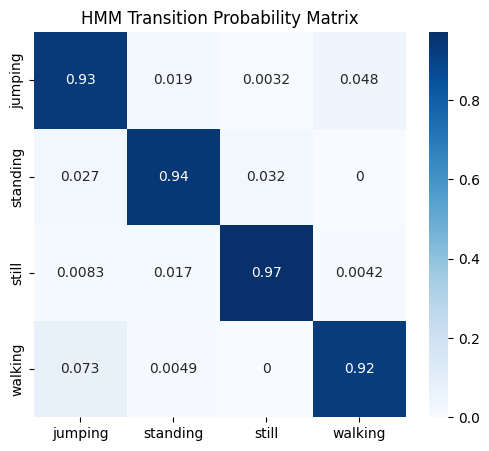

In [7]:

plt.figure(figsize=(6,5))
sns.heatmap(A, annot=True, cmap="Blues", xticklabels=states, yticklabels=states)
plt.title("HMM Transition Probability Matrix")
plt.show()

This matrix was created by computing simple transition frequencies between our activity labels in features.csv.

That means:
- We have real transitions estimated from your labeled sequences.
- But the HMM parameters (like emission probabilities and the actual fitted A matrix) are not yet optimized — they’ll be updated after model training.

# Model Implementation

In [8]:
feature_cols = [c for c in df.columns
                if c not in {"activity", "session_id"} and pd.api.types.is_numeric_dtype(df[c])]
print("using D =", len(feature_cols), "features")
print(feature_cols[:10], "...")


using D = 93 features
['accel_x_mean', 'accel_x_std', 'accel_x_var', 'accel_x_mad', 'accel_y_mean', 'accel_y_std', 'accel_y_var', 'accel_y_mad', 'accel_z_mean', 'accel_z_std'] ...


In [9]:
ts = df["start_time"].to_numpy().astype(float)
threshold = 2.0
gaps = np.diff(ts) > threshold
sess_id = np.concatenate(([0], 1 + np.cumsum(gaps)))
df["session_id"] = sess_id

In [10]:


session_ids = df["session_id"].unique()
# random split 80/20
train_sess, test_sess = train_test_split(session_ids, test_size=0.2, random_state=42)



print("n sessions total:", len(session_ids), "train:", len(train_sess), " test:", len(test_sess))
train_df = df[df["session_id"].isin(train_sess)].reset_index(drop=True)
test_df  = df[df["session_id"].isin(test_sess)].reset_index(drop=True)

# ensure all activities present in train 
print("train activity counts:\n", train_df["label"].value_counts())
print("test activity counts:\n", test_df["label"].value_counts())

n sessions total: 82 train: 65  test: 17
train activity counts:
 label
walking     229
standing    196
still       196
jumping     183
Name: count, dtype: int64
test activity counts:
 label
still       51
jumping     44
walking     37
standing    12
Name: count, dtype: int64


In [12]:
def build_seqs_from_df(df_in, feature_cols, session_col="session_id"):
    seqs_X = []
    seqs_y = []
    for sid in df_in[session_col].drop_duplicates().tolist():
        sub = df_in[df_in[session_col] == sid]
        X = sub[feature_cols].to_numpy(dtype=float)
        y = sub["label"].to_numpy()
        if len(y) > 0:
            seqs_X.append(X)
            seqs_y.append(y)
    return seqs_X, seqs_y

X_train_seqs, y_train_seqs = build_seqs_from_df(train_df, feature_cols, session_col="session_id")
X_test_seqs,  y_test_seqs  = build_seqs_from_df(test_df,  feature_cols, session_col="session_id")

# encode labels (consistent mapping)
unique_labels = []
for y in y_train_seqs + y_test_seqs:
    for v in y:
        if v not in unique_labels:
            unique_labels.append(v)
label2idx = {lab:i for i,lab in enumerate(unique_labels)}
idx2label = {i:lab for lab,i in label2idx.items()}
print("label2idx:", label2idx)

y_train_enc = [np.array([label2idx[v] for v in seq], dtype=int) for seq in y_train_seqs]
y_test_enc  = [np.array([label2idx.get(v, -1) for v in seq], dtype=int) for seq in y_test_seqs]
# (should not contain -1 unless a label appears in test only)

label2idx: {'jumping': 0, 'standing': 1, 'still': 2, 'walking': 3}


In [13]:
scaler = StandardScaler()
all_X_train = np.vstack(X_train_seqs)
scaler.fit(all_X_train)
X_train_scaled = [scaler.transform(X) for X in X_train_seqs]
X_test_scaled  = [scaler.transform(X) for X in X_test_seqs]

In [14]:

def fit_supervised_hmm(X_seqs, y_seqs, n_states, reg=1e-6):
    pi_counts = np.zeros(n_states)
    for y in y_seqs:
        pi_counts[y[0]] += 1
    pi = (pi_counts + 1e-8) / (pi_counts.sum() + 1e-8)
    A_counts = np.zeros((n_states, n_states))
    for y in y_seqs:
        for t in range(len(y)-1):
            A_counts[y[t], y[t+1]] += 1
    A = (A_counts + 1e-8)
    row_sums = A.sum(axis=1, keepdims=True)
    zero_rows = (row_sums.flatten() == 0)
    if zero_rows.any():
        A[zero_rows] = 1.0 / n_states
        row_sums = A.sum(axis=1, keepdims=True)
    A = A / row_sums
    D = X_seqs[0].shape[1]
    means = np.zeros((n_states, D))
    covs  = np.zeros((n_states, D, D))
    accum = {s: [] for s in range(n_states)}
    for X,y in zip(X_seqs, y_seqs):
        for xi, yi in zip(X,y):
            accum[yi].append(xi)
    for s in range(n_states):
        if len(accum[s]) == 0:
            means[s] = np.zeros(D)
            covs[s]  = np.eye(D) * (1.0 + reg)
        else:
            arr = np.vstack(accum[s])
            means[s] = arr.mean(axis=0)
            cov = np.cov(arr, rowvar=False)
            if cov.ndim == 0:
                cov = cov.reshape((1,1))
            cov += np.eye(D) * reg
            covs[s] = cov
    return pi, A, means, covs

def log_emission(X, means, covs):
    T = X.shape[0]
    S = means.shape[0]
    ll = np.zeros((T, S))
    for s in range(S):
        rv = multivariate_normal(mean=means[s], cov=covs[s], allow_singular=True)
        ll[:, s] = rv.logpdf(X)
    return ll

def viterbi(X, pi, A, means, covs):
    T = X.shape[0]
    S = pi.shape[0]
    logpi = np.log(pi + 1e-12)
    logA = np.log(A + 1e-12)
    logB = log_emission(X, means, covs)
    dp = np.full((T, S), -np.inf)
    ptr = np.zeros((T, S), dtype=int)
    dp[0] = logpi + logB[0]
    for t in range(1, T):
        for s in range(S):
            vals = dp[t-1] + logA[:, s]
            k = np.argmax(vals)
            dp[t, s] = vals[k] + logB[t, s]
            ptr[t, s] = k
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(dp[-1])
    for t in range(T-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

n_states = len(label2idx)
pi, A, means, covs = fit_supervised_hmm(X_train_scaled, y_train_enc, n_states)
print("pi:", pi)
print("A:\n", A)

# decode test sequences
y_test_pred_enc = [viterbi(X, pi, A, means, covs) for X in X_test_scaled]
# optional: also decode train to inspect training fit
y_train_pred_enc = [viterbi(X, pi, A, means, covs) for X in X_train_scaled]

pi: [0.2        0.27692308 0.21538462 0.30769231]
A:
 [[9.94117647e-01 5.88235300e-03 5.88235294e-11 5.88235294e-11]
 [5.58659218e-11 9.88826815e-01 1.11731844e-02 5.58659218e-11]
 [5.52486188e-11 5.52486188e-11 9.94475138e-01 5.52486193e-03]
 [4.78468904e-03 4.78468899e-11 4.78468899e-11 9.95215311e-01]]


In [15]:
# F: evaluate on test (unseen sessions) and print table per requested format
import numpy as np
from sklearn.metrics import confusion_matrix

# flatten
y_test_true_flat = np.concatenate(y_test_enc)
y_test_pred_flat = np.concatenate(y_test_pred_enc)

cm = confusion_matrix(y_test_true_flat, y_test_pred_flat, labels=list(range(n_states)))
TP = np.diag(cm).astype(float)
FN = cm.sum(axis=1) - TP
FP = cm.sum(axis=0) - TP
TN = cm.sum() - (TP + FN + FP)
with np.errstate(divide='ignore', invalid='ignore'):
    sensitivity = np.where((TP + FN) > 0, TP / (TP + FN), np.nan)
    specificity = np.where((TN + FP) > 0, TN / (TN + FP), np.nan)
overall_accuracy = TP.sum() / cm.sum() if cm.sum() > 0 else np.nan

print("Confusion matrix:\n", cm)
print("\nDeliverable table (State, Number of Samples, Sensitivity, Specificity):")
for s in range(n_states):
    print(f"{idx2label[s]}, {int((y_test_true_flat==s).sum())}, {sensitivity[s]:.3f}, {specificity[s]:.3f}")
print("\nOverall accuracy:", overall_accuracy)

Confusion matrix:
 [[22  2 19  1]
 [ 0  0 12  0]
 [ 0  0 49  2]
 [ 0  0  0 37]]

Deliverable table (State, Number of Samples, Sensitivity, Specificity):
jumping, 44, 0.500, 1.000
standing, 12, 0.000, 0.985
still, 51, 0.961, 0.667
walking, 37, 1.000, 0.972

Overall accuracy: 0.75


In [16]:
# G: visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# transition matrix heatmap
plt.figure(figsize=(5,4))
labels = [idx2label[i] for i in range(n_states)]
sns.heatmap(A, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap="viridis")
plt.xlabel("to state"); plt.ylabel("from state"); plt.title("Transition matrix A"); plt.show()

# timeline for test (concatenate test sessions)
true_cat = np.concatenate(y_test_enc)
pred_cat = np.concatenate(y_test_pred_enc)
plt.figure(figsize=(12,2))
t = np.arange(len(true_cat))
plt.step(t, true_cat, where='post', label='true')
plt.step(t, pred_cat, where='post', label='pred', alpha=0.8)
plt.yticks(list(range plt.legend(); plt.title("True vs Predicted timeline (test)"); plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (4207796358.py, line 19)